# Using RNN (LSTM/GRU) on a Time Series - Alcohol Sales Forecast
In this project, we're using data from the Federal Reserve Economic Database concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2020.

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

# Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
import matplotlib.pyplot as plt

plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

# Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [3]:
df = pd.read_csv('Data/Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

337

In [4]:
# Always a good idea with time series data:
# There is no right or wrong here
# You can either drop the null value rows or you can replace null with mean
df.dropna(inplace=True)
len(df)

337

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.tail()

,S4248SM144NCEN
DATE,
2019-09-01,13215
2019-10-01,14680
2019-11-01,14014
2019-12-01,16464
2020-01-01,10843


# Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

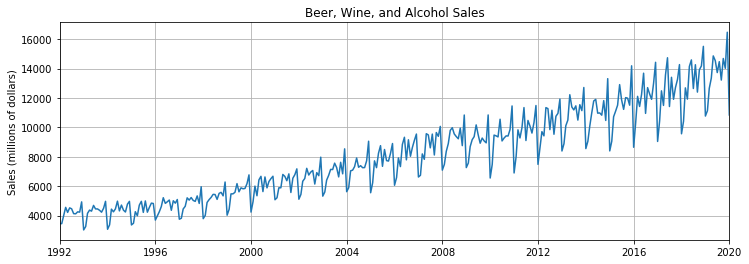

In [7]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN']) # name of the column given by Fed
plt.show()

# Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [8]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [9]:
test_set

array([11134., 12653., 13341., 14855., 14530., 13724., 14464., 13215.,
       14680., 14014., 16464., 10843.])

# Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>

We want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [11]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [12]:
train_norm.min()

-1.0

In [18]:
train_norm.max()

1.0000000000000002

In [19]:
train_norm.mean()

-0.22142967270843472

In [20]:
type(train_norm)

numpy.ndarray

# Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [23]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
# ws is the window size
def input_data(seq, ws):  
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)  # this should equal 337-12-12

313

In [27]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9314, -0.9315, -0.8443, -0.7542, -0.8092, -0.7598, -0.7699, -0.8227,
         -0.8244, -0.8031, -0.8061, -0.6945]), tensor([-1.]))

In [28]:
# Display the 2nd seq/label tuple in the train data
train_data[1]

(tensor([-0.9315, -0.8443, -0.7542, -0.8092, -0.7598, -0.7699, -0.8227, -0.8244,
         -0.8031, -0.8061, -0.6945, -1.0000]), tensor([-0.9631]))

In [29]:
# Display the 3rd seq/label tuple in the train data
train_data[2]

(tensor([-0.8443, -0.7542, -0.8092, -0.7598, -0.7699, -0.8227, -0.8244, -0.8031,
         -0.8061, -0.6945, -1.0000, -0.9631]), tensor([-0.8190]))

# Define the model
This time we'll use an LSTM layer of size (1,100).

In [33]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super(LSTMnetwork, self).__init__()
        
        # Hidden dimensions
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size, output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

# Instantiate the model, define loss and optimization functions

In [34]:
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [35]:
# parameters depth
len(list(model.parameters()))

6

In [36]:
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 1])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([1, 100])
torch.Size([1])


# Train the model

In [37]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.27213061
Epoch:  2 Loss: 0.23486409
Epoch:  3 Loss: 0.36305246
Epoch:  4 Loss: 0.23926432
Epoch:  5 Loss: 0.23267537
Epoch:  6 Loss: 0.21156687
Epoch:  7 Loss: 0.19906308
Epoch:  8 Loss: 0.18158565
Epoch:  9 Loss: 0.15881790
Epoch: 10 Loss: 0.15318750
Epoch: 11 Loss: 0.15143064
Epoch: 12 Loss: 0.15995049
Epoch: 13 Loss: 0.16027461
Epoch: 14 Loss: 0.15402775
Epoch: 15 Loss: 0.15876684
Epoch: 16 Loss: 0.15029652
Epoch: 17 Loss: 0.14277886
Epoch: 18 Loss: 0.11314578
Epoch: 19 Loss: 0.08872589
Epoch: 20 Loss: 0.08905081
Epoch: 21 Loss: 0.32246891
Epoch: 22 Loss: 0.27161974
Epoch: 23 Loss: 0.25211734
Epoch: 24 Loss: 0.22751518
Epoch: 25 Loss: 0.19006512
Epoch: 26 Loss: 0.32366836
Epoch: 27 Loss: 0.24500629
Epoch: 28 Loss: 0.15842056
Epoch: 29 Loss: 0.20487115
Epoch: 30 Loss: 0.09797894
Epoch: 31 Loss: 0.22789279
Epoch: 32 Loss: 0.22984600
Epoch: 33 Loss: 0.22901720
Epoch: 34 Loss: 0.21031110
Epoch: 35 Loss: 0.17113298
Epoch: 36 Loss: 0.13098751
Epoch: 37 Loss: 0.05924523
E

# Run predictions and compare to known test set

In [38]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [39]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.33301711082458496,
 0.7367620468139648,
 0.5133174657821655,
 0.9044288992881775,
 0.9145219326019287,
 0.8605539798736572,
 1.0474084615707397,
 0.7919925451278687,
 1.1076383590698242,
 1.0473488569259644,
 1.1243133544921875,
 0.46243613958358765]

# Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [40]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[11344.36121166],
       [13862.31650496],
       [12468.80437535],
       [14907.97083041],
       [14970.91603267],
       [14634.34489548],
       [15799.66287059],
       [14206.76150769],
       [16175.28662634],
       [15799.29114622],
       [16279.28023529],
       [12151.48298451]])

In [41]:
df['S4248SM144NCEN'][-12:]

DATE
2019-02-01    11134
2019-03-01    12653
2019-04-01    13341
2019-05-01    14855
2019-06-01    14530
2019-07-01    13724
2019-08-01    14464
2019-09-01    13215
2019-10-01    14680
2019-11-01    14014
2019-12-01    16464
2020-01-01    10843
Name: S4248SM144NCEN, dtype: int64

# It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [48]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-04-01', '2020-04-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01'],
      dtype='datetime64[D]')

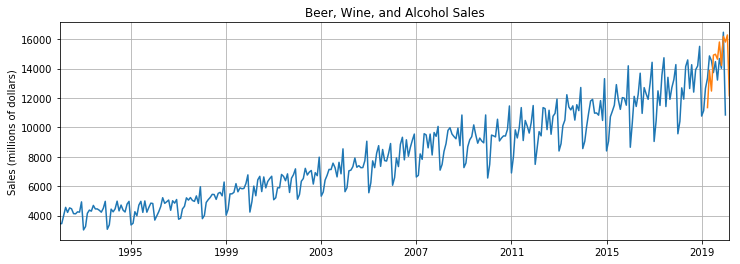

In [49]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

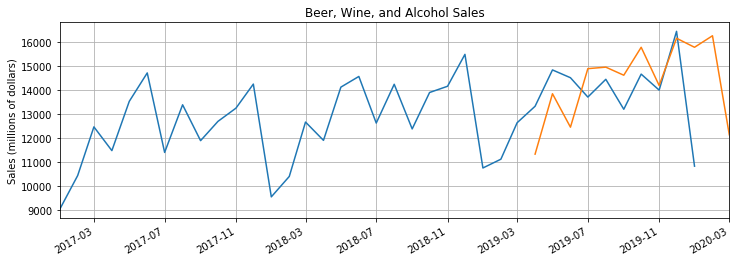

In [50]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [52]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00000716
Epoch:  2 Loss: 0.00057569
Epoch:  3 Loss: 0.00000475
Epoch:  4 Loss: 0.00318039
Epoch:  5 Loss: 0.00000296
Epoch:  6 Loss: 0.00535440
Epoch:  7 Loss: 0.00157587
Epoch:  8 Loss: 0.00066996
Epoch:  9 Loss: 0.00001635
Epoch: 10 Loss: 0.00019139
Epoch: 11 Loss: 0.00078499
Epoch: 12 Loss: 0.00206006
Epoch: 13 Loss: 0.00030018
Epoch: 14 Loss: 0.00004410
Epoch: 15 Loss: 0.00191987
Epoch: 16 Loss: 0.00007019
Epoch: 17 Loss: 0.00000234
Epoch: 18 Loss: 0.06088843
Epoch: 19 Loss: 0.00000417
Epoch: 20 Loss: 0.00005600
Epoch: 21 Loss: 0.00000887
Epoch: 22 Loss: 0.00005473
Epoch: 23 Loss: 0.00006495
Epoch: 24 Loss: 0.00005274
Epoch: 25 Loss: 0.00000278
Epoch: 26 Loss: 0.00063272
Epoch: 27 Loss: 0.00016414
Epoch: 28 Loss: 0.00008934
Epoch: 29 Loss: 0.00003102
Epoch: 30 Loss: 0.00002161
Epoch: 31 Loss: 0.00011580
Epoch: 32 Loss: 0.00009500
Epoch: 33 Loss: 0.00008028
Epoch: 34 Loss: 0.00000129
Epoch: 35 Loss: 0.00076566
Epoch: 36 Loss: 0.00007239
Epoch: 37 Loss: 0.00028869
E

# Predict future values, plot the result

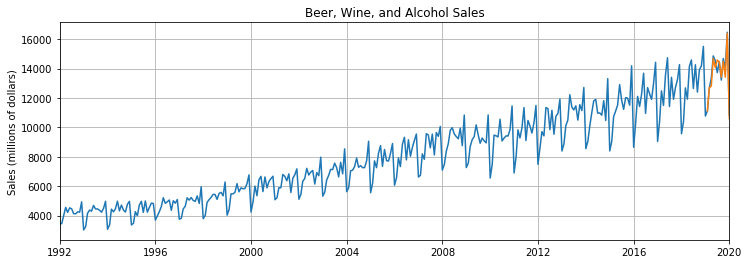

In [53]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

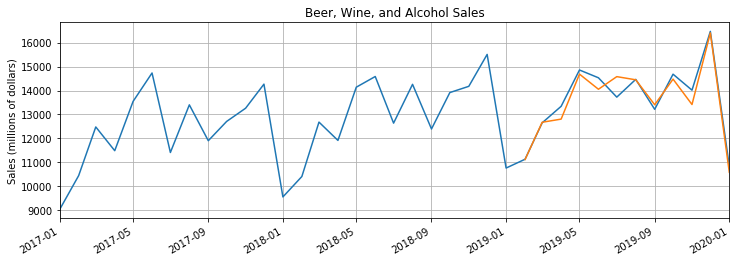

In [54]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

# DONE

<h3>BONUS:</h3>To save time in the future, we've written a function that will take in a time series training data set, and output a tensor of <tt>(seq, label)</tt> tuples.

In [56]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('data/Alcohol_Sales.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [57]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [59]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data) 

313

In [60]:
train_data[0]

(tensor([-0.9314, -0.9315, -0.8443, -0.7542, -0.8092, -0.7598, -0.7699, -0.8227,
         -0.8244, -0.8031, -0.8061, -0.6945]), tensor([-1.]))

In [62]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples

